# exp005

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import optuna

sns.set_style("darkgrid")
%matplotlib inline

c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの読み込み

In [4]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## RMSLEの定義

In [5]:
def feval_rmsle(preds, data):
    y_true = data.get_label()
    preds = np.clip(preds, 0, None)  # 0より小さい値を0に置換
    rmsle = np.sqrt(mean_squared_log_error(y_true, preds))
    return 'RMSLE', rmsle, False

## 特徴量エンジニアリング

In [6]:
df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
df = df.drop(["casual", "registered"], axis=1)

In [7]:
datetime = pd.to_datetime(df["datetime"])
df["year"] = datetime.dt.year
df["month"] = datetime.dt.month
df["day"] = datetime.dt.day
df["hour"] = datetime.dt.hour
df["dayofweek"] = datetime.dt.day_name()
df["dayofweek"] = df["dayofweek"].map({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6})
df = df.drop("datetime", axis=1)

In [8]:
df["count"] = df["count"].apply(lambda x: np.log(x))

In [9]:
train_df = df[~df["count"].isnull()].reset_index(drop=True)
test_df = df[df["count"].isnull()].drop("count", axis=1).reset_index(drop=True)

In [15]:
model_path = Path("../output/model005")

## Optunaによるパラメータチューニング

In [37]:
def objective(trial, df, model_path):
    params = {
        'objective': 'regression',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 0.01, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    X_train, X_valid = train_test_split(df, test_size=0.2, random_state=42)

    y_train = X_train["count"]
    y_valid = X_valid["count"]
    X_train.drop(["count"], axis=1, inplace=True)
    X_valid.drop(["count"], axis=1, inplace=True)

    train_set = lgb.Dataset(X_train, y_train)
    valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

    model = lgb.train(
        params=params,
        train_set=train_set,
        valid_sets=[train_set, valid_set],
        num_boost_round=10000,
        feval=feval_rmsle,
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=True)
        ]
    )

    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = np.clip(y_pred, 0, None)
    y_pred = np.exp(y_pred)
    y_valid = np.exp(y_valid)

    return np.sqrt(mean_squared_log_error(y_valid, y_pred))

In [38]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df, model_path), n_trials=10)

[I 2023-10-30 00:52:00,973] A new study created in memory with name: no-name-8d616e9b-3328-4f75-8401-a2666c75a28c


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 2.19257	training's RMSLE: 0.357461	valid_1's l2: 2.25985	valid_1's RMSLE: 0.366717


[I 2023-10-30 00:52:22,321] Trial 0 finished with value: 1.4311896906831412 and parameters: {'lambda_l1': 6.385741607729849e-05, 'lambda_l2': 0.0026946688340939075, 'num_leaves': 222, 'learning_rate': 4.757936716095961e-07, 'feature_fraction': 0.4458458973461459, 'bagging_fraction': 0.4495450235183903, 'min_child_samples': 81}. Best is trial 0 with value: 1.4311896906831412.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 0.813175	training's RMSLE: 0.25208	valid_1's l2: 0.873941	valid_1's RMSLE: 0.262966


[I 2023-10-30 00:52:43,888] Trial 1 finished with value: 0.8703619756227867 and parameters: {'lambda_l1': 0.4684111239935487, 'lambda_l2': 0.8389869027088399, 'num_leaves': 123, 'learning_rate': 9.301513082078448e-05, 'feature_fraction': 0.5002011704857029, 'bagging_fraction': 0.6690315139930043, 'min_child_samples': 59}. Best is trial 1 with value: 0.8703619756227867.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 2.13236	training's RMSLE: 0.35401	valid_1's l2: 2.19977	valid_1's RMSLE: 0.363324


[I 2023-10-30 00:53:06,793] Trial 2 finished with value: 1.411218760303981 and parameters: {'lambda_l1': 3.0748720000719714e-05, 'lambda_l2': 3.0973353977397014e-08, 'num_leaves': 153, 'learning_rate': 3.066071407117356e-06, 'feature_fraction': 0.4976507663885281, 'bagging_fraction': 0.880413082922277, 'min_child_samples': 63}. Best is trial 1 with value: 0.8703619756227867.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5785]	training's l2: 0.0855222	training's RMSLE: 0.100028	valid_1's l2: 0.11094	valid_1's RMSLE: 0.112058


[I 2023-10-30 00:53:14,910] Trial 3 finished with value: 0.30337019347041294 and parameters: {'lambda_l1': 2.00241527927484e-06, 'lambda_l2': 0.07548976075029933, 'num_leaves': 21, 'learning_rate': 0.001902802942926122, 'feature_fraction': 0.5303954371423307, 'bagging_fraction': 0.8452381729185424, 'min_child_samples': 23}. Best is trial 3 with value: 0.30337019347041294.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9255]	training's l2: 0.0173108	training's RMSLE: 0.0461223	valid_1's l2: 0.101077	valid_1's RMSLE: 0.112255


[I 2023-10-30 00:54:00,820] Trial 4 finished with value: 0.28563141600425346 and parameters: {'lambda_l1': 1.802094642355946e-05, 'lambda_l2': 0.12483430281141393, 'num_leaves': 233, 'learning_rate': 0.0008449355393514154, 'feature_fraction': 0.7821650468454825, 'bagging_fraction': 0.586528606931789, 'min_child_samples': 9}. Best is trial 4 with value: 0.28563141600425346.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 0.361429	training's RMSLE: 0.187737	valid_1's l2: 0.414016	valid_1's RMSLE: 0.200293


[I 2023-10-30 00:54:30,356] Trial 5 finished with value: 0.5883953711570272 and parameters: {'lambda_l1': 1.6430470658444635e-08, 'lambda_l2': 0.03434013286894881, 'num_leaves': 233, 'learning_rate': 0.00015891656354868818, 'feature_fraction': 0.6342353874761418, 'bagging_fraction': 0.6144276809296686, 'min_child_samples': 47}. Best is trial 4 with value: 0.28563141600425346.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 0.251231	training's RMSLE: 0.162661	valid_1's l2: 0.283136	valid_1's RMSLE: 0.172615


[I 2023-10-30 00:55:05,135] Trial 6 finished with value: 0.4836705502191375 and parameters: {'lambda_l1': 0.1946834105327758, 'lambda_l2': 0.00012111524852807679, 'num_leaves': 186, 'learning_rate': 0.00014206117351581206, 'feature_fraction': 0.9673705189483458, 'bagging_fraction': 0.8964393425929946, 'min_child_samples': 29}. Best is trial 4 with value: 0.28563141600425346.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 0.0611704	training's RMSLE: 0.0864279	valid_1's l2: 0.100713	valid_1's RMSLE: 0.110223


[I 2023-10-30 00:55:24,772] Trial 7 finished with value: 0.28690298000827424 and parameters: {'lambda_l1': 0.024152880486628774, 'lambda_l2': 6.881579967711247, 'num_leaves': 52, 'learning_rate': 0.0008911840963099941, 'feature_fraction': 0.6615219681948359, 'bagging_fraction': 0.8431784023348028, 'min_child_samples': 8}. Best is trial 4 with value: 0.28563141600425346.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 2.13476	training's RMSLE: 0.354079	valid_1's l2: 2.20034	valid_1's RMSLE: 0.363289


[I 2023-10-30 00:55:49,240] Trial 8 finished with value: 1.41146313042253 and parameters: {'lambda_l1': 5.770157627927548e-05, 'lambda_l2': 1.3974323004573853e-05, 'num_leaves': 184, 'learning_rate': 1.7985202670937097e-06, 'feature_fraction': 0.9682062607351845, 'bagging_fraction': 0.9789076375758754, 'min_child_samples': 67}. Best is trial 4 with value: 0.28563141600425346.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6976]	training's l2: 0.064636	training's RMSLE: 0.0890781	valid_1's l2: 0.104552	valid_1's RMSLE: 0.112027


[I 2023-10-30 00:56:04,126] Trial 9 finished with value: 0.29219586604687225 and parameters: {'lambda_l1': 9.289485913028614e-05, 'lambda_l2': 0.008380747639659037, 'num_leaves': 67, 'learning_rate': 0.0010146902058894905, 'feature_fraction': 0.7873038544718542, 'bagging_fraction': 0.6105726787045075, 'min_child_samples': 39}. Best is trial 4 with value: 0.28563141600425346.


In [39]:
print(f"Best trial: {study.best_trial.params}")

Best trial: {'lambda_l1': 1.802094642355946e-05, 'lambda_l2': 0.12483430281141393, 'num_leaves': 233, 'learning_rate': 0.0008449355393514154, 'feature_fraction': 0.7821650468454825, 'bagging_fraction': 0.586528606931789, 'min_child_samples': 9}


In [40]:
best_params = {
    'lambda_l1': 1.802094642355946e-05, 
    'lambda_l2': 0.12483430281141393, 
    'num_leaves': 233, 
    'learning_rate': 0.0008449355393514154, 
    'feature_fraction': 0.7821650468454825, 
    'bagging_fraction': 0.586528606931789, 
    'min_child_samples': 9
}

## train

In [41]:
def train(df, model_path):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": "regression",
            "seed": 42,
            **best_params
        }

        train_set = lgb.Dataset(X_train, y_train)
        valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

        model = lgb.train(
            params=params,
            train_set=train_set,
            valid_sets=[train_set, valid_set],
            num_boost_round=10000,
            feval=feval_rmsle,
            callbacks=[
                lgb.early_stopping(stopping_rounds=10, verbose=True),
                lgb.log_evaluation(period=10)
            ]
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(X_valid)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        y_valid = np.exp(y_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"model_fold{fold+1:03d}.bin", num_iteration=model.best_iteration)

    return sum(fold_rmsles) / len(fold_rmsles)

In [43]:
train_rmsle = train(train_df, model_path)
print(f"RMSLE: {train_rmsle}")

start training for fold 0
start training
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 13
[LightGBM] [Info] Start training from score 4.555325
Training until validation scores don't improve for 10 rounds
[10]	training's l2: 2.17466	training's RMSLE: 0.35642	valid_1's l2: 2.24262	valid_1's RMSLE: 0.365732
[20]	training's l2: 2.14255	training's RMSLE: 0.354548	valid_1's l2: 2.21032	valid_1's RMSLE: 0.363878
[30]	training's l2: 2.11256	training's RMSLE: 0.352787	valid_1's l2: 2.18037	valid_1's RMSLE: 0.362149
[40]	training's l2: 2.08332	training's RMSLE: 0.351052	valid_1's l2: 2.15122	valid_1's RMSLE: 0.360446
[50]	training's l2: 2.05436	training's RMSLE: 0.349321	valid_1's l2: 2.12235	valid_1's RMSLE: 0.358747
[60]	training's l2: 2.02633	training's RMSLE

## evaluate

In [44]:
def evaluate(df, model_path):
    predictions = []

    for fold in range(5):
        print(f"loading model for fold {fold}")
        model = lgb.Booster(model_file=model_path / f"model_fold{fold+1:03d}.bin")

        print(f"start evaluate for fold {fold}")
        X_test = df.copy()

        print(f"predict test for fold {fold}")
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        predictions.append(y_pred)
    
    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [45]:
y_pred = evaluate(test_df, model_path)
y_pred

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([ 12.83079055,   5.34400925,   5.28066251, ..., 119.16860521,
        90.23524636,  49.20622784])

In [46]:
submission = pd.read_csv(input_path / "sampleSubmission.csv")
submission["count"] = y_pred
submission.to_csv("../output/submission005.csv", index=False)

## Result

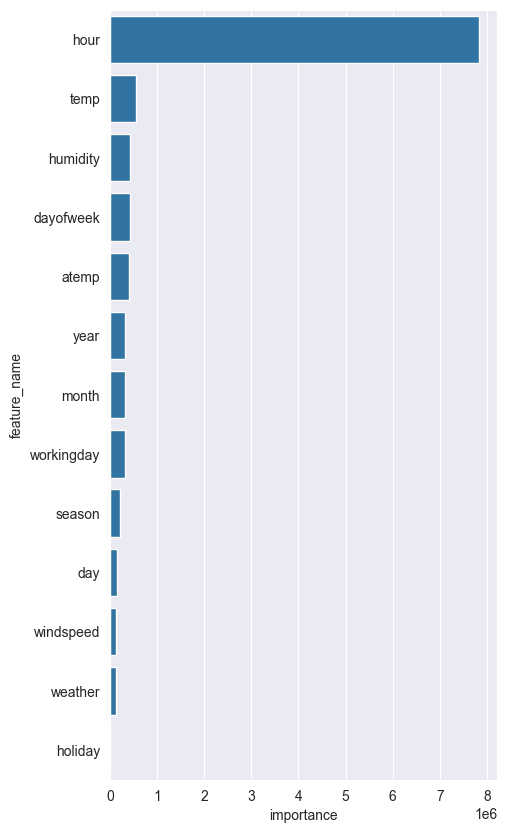

In [47]:
model = lgb.Booster(model_file=model_path / f"model_fold001.bin")
importance_df = pd.DataFrame()

importance_df["importance"] = model.feature_importance(importance_type="gain")
importance_df["feature_name"] = model.feature_name()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()